In [4]:
import json
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.neural_network import MLPClassifier

In [5]:
# Constants

# File paths
TWEETS_FP = "tweets.json"
TRAIN_DEV_FP = "labels-train+dev.tsv"
TEST_FP = "labels-test.tsv"

# Column names
COL_ID = 'ID'
COL_TWEET = 'Tweet'
COL_LABEL = 'Label'

# minimum number of instances that we require to be present in the training set
# for a given language to be included in fitting of the model
MIN_NR_OCCURENCES = 10

# unknown class name
CLASS_UNK = 'unknown'

---
# Data

## Tweets

In [6]:
def get_tweets():
    """Return a dataframe of tweets"""
    tweets = []
    with open(TWEETS_FP, 'r') as tweets_fh:  # Tweets file handle
        for line in tweets_fh:   # put each line in a list of lines
            j_content = json.loads(line)
            tweets.append(j_content)

    # make a dataframe out of it
    tweets = pd.DataFrame(tweets, columns=[COL_ID, COL_TWEET])
    return tweets

## Labels

In [7]:
def get_train_labels():
    """Return a dataframe of train_dev labels"""
    train_dev_labels = pd.read_csv(
        TRAIN_DEV_FP,
        sep='\t',
        header=None,
        names=[COL_LABEL, COL_ID]
    )
    # remove whitespace from labels (e.g. "ar  " should be equal to "ar")
    train_dev_labels.Label = train_dev_labels.Label.str.strip()

    # deal with class imbalance in the train set
    lang_occurence = train_dev_labels.groupby(COL_LABEL).size()
    balanced_languages = lang_occurence.where(
        lang_occurence >= MIN_NR_OCCURENCES
    ).dropna().index.values
    balanced_labels = train_dev_labels.Label.isin(balanced_languages)


    # Option 1 - replace rows that are labelled with an imbalanced language
    # ~ is element-wise logical not
    train_dev_labels.loc[~balanced_labels, COL_LABEL] = CLASS_UNK

    # Option 2 - keep the rows that are labelled with a balanced language
    # train_dev_labels = train_dev_labels[balanced_labels]
    return train_dev_labels

def get_test_labels():
    """Return a dataframe of test labels"""
    return pd.read_csv(
        TEST_FP,
        sep='\t',
        header=None,
        names=[COL_LABEL, COL_ID]
    )

### Splitting

In [8]:
def create_sets(tweets, train_dev_labels, test_labels, use_dev=True):
    """Return a tuple of dataframes comprising three main data sets"""
    # to allow for merge, need the same type
    tweets[COL_ID] = tweets[COL_ID].astype(int)

    # Merge by ID
    train_dev_data = pd.merge(tweets, train_dev_labels, on=COL_ID)
    test_data = pd.merge(tweets, test_labels, on=COL_ID)

    # Util function
    def drop_n_shuffle(data):
        data_no_na = data.dropna().copy()
        return data_no_na.sample(frac=1)

    frac = 1
    if use_dev:
        frac = 0.9

    train_dev_data_prepared = drop_n_shuffle(
        train_dev_data
    ).reset_index(drop=True)
    # take 90% of the data, reshuffle
    train_set = train_dev_data_prepared.sample(frac=frac, random_state=0)
    # take 10% that remain
    dev_set = train_dev_data_prepared.drop(train_set.index)
    test_set = drop_n_shuffle(test_data)

    # drop the ID columns, not needed anymore
    train = train_set.drop(COL_ID, axis=1)
    dev = dev_set.drop(COL_ID, axis=1)
    test = test_set.drop(COL_ID, axis=1)

    return train, dev, test

In [9]:
def preprocess():
    """Return the three main sets used in the pipelines"""
    tweets = get_tweets()
    train_labels = get_train_labels()
    test_labels = get_test_labels()
    return create_sets(tweets, train_labels, test_labels, use_dev=False)

In [13]:
train, dev, test = preprocess()

X_train = train.Tweet 
y_train = train.Label
X_dev = dev.Tweet
y_dev = dev.Label
X_test = test.Tweet
y_test = test.Label

# Part 1 - Language classification with linear classification

## Multinomial Naïve Bayes

In [14]:
#Average word length extractor, inspired  by https://michelleful.github.io/code-blog/2015/06/20/pipelines/)
class AverageWordLengthExtractor(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts tweet column, outputs average word length"""

    def __init__(self):
        pass

    def average_word_length(self, tweet):
        """Helper code to compute average word length of a tweet"""
        return np.mean([len(word) for word in tweet.split()])

    def transform(self, df, y=None):
        """The workhorse of this feature extractor"""
        # the result of the transform needs to be a 2d array a.k.a. dataframe
        # https://stackoverflow.com/a/50713209
        result = df.apply(self.average_word_length).to_frame()
        return result

    def fit(self, df, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [11]:
pipeline_NB = Pipeline([
    ('features', FeatureUnion([
        # first feature
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(analyzer='word')),
            ('tfidf', TfidfTransformer())
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('nb_clf', MultinomialNB(fit_prior=False)) # classifier
])

param_grid1 = {'nb_clf__alpha': [0.2, 0.4, 0.6],
                'features__ngram_tfidf__ngram__ngram_range': [(1, 2), (1, 3), (1, 4)]}

In [12]:
# gs_NB = GridSearchCV(pipeline_NB, param_grid1, cv=4, n_jobs=-1, verbose=10)
# gs_NB.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  2.2min remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.3min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('ngram_tfidf', Pipeline(memory=None,
     steps=[('ngram', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max...transformer_weights=None)), ('nb_clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'nb_clf__alpha': [0.2, 0.4, 0.6], 'features__ngram_tfidf__ngram__ngram_range': [(1, 2), (1, 3), (1, 4)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [13]:
# y_NB = gs_NB.predict(X_dev)
# accuracy_score(y_dev, y_NB)

0.8500093510379653

### Results

In [16]:
res = pd.DataFrame.from_dict(gs_NB.cv_results_)
res.sort_values(by='rank_test_score')[['rank_test_score', 'param_features__ngram_tfidf__ngram__ngram_range', 'param_nb_clf__alpha', 'mean_test_score']]

,rank_test_score,param_features__ngram_tfidf__ngram__ngram_range,param_nb_clf__alpha,mean_test_score
0,1,"(1, 2)",0.2,0.843938
3,2,"(1, 3)",0.2,0.842047
6,3,"(1, 4)",0.2,0.840073
1,4,"(1, 2)",0.4,0.835855
4,5,"(1, 3)",0.4,0.833195
7,6,"(1, 4)",0.4,0.831719
2,7,"(1, 2)",0.6,0.830286
5,8,"(1, 3)",0.6,0.827584
8,9,"(1, 4)",0.6,0.825735


In [15]:
def train_and_predict_MNB(X_train, y_train):
    """Return the Multinomial Naïve Bayes model trained on the parameters"""
    multinomial_NB = Pipeline([
        ('features', FeatureUnion([
            ('ngram_tfidf', Pipeline([
                ('ngram', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer())
            ])),
            ('ave_scaled', Pipeline([
                ('ave', AverageWordLengthExtractor()),
                ('scale', MinMaxScaler())
            ]))
        ])),
        ('nb_clf', MultinomialNB(fit_prior=False, alpha=0.1)) # classifier
    ])
    # train
    multinomial_NB.fit(X_train, y_train)
    return multinomial_NB

In [16]:
train_full, _, _ = preprocess() # no dev set split

X_train_full = train_full.Tweet
y_train_full = train_full.Label

best_nb = train_and_predict_MNB(X_train_full, y_train_full)

In [18]:
best_nb_predicted = best_nb.predict(X_test)

accuracy = accuracy_score(y_test, best_nb_predicted)
print(accuracy)
best_nb_conf_mx = confusion_matrix(y_test, best_nb_predicted)
best_nb_conf_mx

0.8776390127862028


array([[513,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [46]:
first_lan = best_nb_conf_mx[10, 10]
second_lan = best_nb_conf_mx[11, 11]
third_lan = best_nb_conf_mx[23, 23]

print(first_lan, second_lan, third_lan)

test.groupby(COL_LABEL).size().to_frame().sort_values(by=0, ascending=False)

4728 1452 2222


,0
Label,
en,4823
ja,2505
es,1495
und,1244
id,827
pt,711
ar,542
ru,244
fr,227


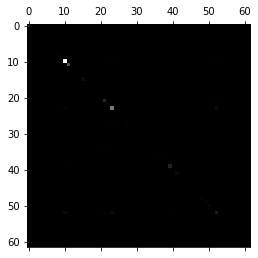

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(best_nb_conf_mx, cmap=plt.cm.gray)
plt.show()

## SGD

In [29]:
pipeline_SGD = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 4), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge' ))# classifier
])

In [30]:
grid_param_SGD = {'SGD_clf__penalty': ['none', 'l2'],
                  'SGD_clf__max_iter': [100, 150, 200]}

In [31]:
gs_SGD = GridSearchCV(pipeline_SGD, grid_param_SGD, cv=4, n_jobs=-1, verbose=10)
gs_SGD.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 16.3min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 20.7min finished
/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (whic

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=None,
       transformer_list=[('ngram_tfidf', Pipeline(memory=None,
     steps=[('ngram', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'SGD_clf__penalty': ['none', 'l2'], 'SGD_clf__max_iter': [100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [32]:
y_SGD = gs_SGD.predict(X_dev)
accuracy_score(y_dev, y_SGD)

0.8479521226856181

In [33]:
res = pd.DataFrame.from_dict(gs_SGD.cv_results_)
res.sort_values(by='rank_test_score')[['rank_test_score', 'param_SGD_clf__max_iter', 'param_SGD_clf__penalty', 'mean_test_score']]

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/debora

,rank_test_score,param_SGD_clf__max_iter,param_SGD_clf__penalty,mean_test_score
4,1,200,none,0.843440
2,2,150,none,0.842442
0,3,100,none,0.841819
1,4,100,l2,0.798450
5,4,200,l2,0.798450
3,6,150,l2,0.798429


In [34]:
#test three best models on the dev set
best_SGD1 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 4), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=200, penalty=None ))# classifier
])

best_SGD1.fit(X_train, y_train)

y_SGD1 = best_SGD1.predict(X_dev)
accuracy_score(y_dev, y_SGD1)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8490742472414438

In [35]:
best_SGD2 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 4), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=150, penalty=None ))# classifier
])

best_SGD2.fit(X_train, y_train)

y_SGD2 = best_SGD2.predict(X_dev)
accuracy_score(y_dev, y_SGD2)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.847204039648401

In [36]:
best_SGD3 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 4), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=100, penalty=None ))# classifier
])

best_SGD3.fit(X_train, y_train)

y_SGD3 = best_SGD3.predict(X_dev)
accuracy_score(y_dev, y_SGD3)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8485131849635309

In [38]:
#try one more Grid Search with playing around with ngrams!

new_pipeline_SGD = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', penalty = None ))# classifier
])

new_grid = {'feats__ngram_tfidf__ngram__ngram_range': [(1, 2), (1, 3)],
                  'SGD_clf__max_iter': [200, 300]}

new_gs_SGD = GridSearchCV(new_pipeline_SGD, new_grid, cv=4, n_jobs=-1, verbose=10)
new_gs_SGD.fit(X_train, y_train)



Fitting 4 folds for each of 4 candidates, totalling 16 fits


/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 11.1min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 15.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 15.6min finished
/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no 

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=None,
       transformer_list=[('ngram_tfidf', Pipeline(memory=None,
     steps=[('ngram', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'feats__ngram_tfidf__ngram__ngram_range': [(1, 2), (1, 3)], 'SGD_clf__max_iter': [200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [39]:
new_y_SGD = new_gs_SGD.predict(X_dev)
accuracy_score(new_y_SGD, y_dev)

0.8556199738170936

In [42]:
new_res = pd.DataFrame.from_dict(new_gs_SGD.cv_results_)
new_res.sort_values(by='rank_test_score')[['rank_test_score', 'param_SGD_clf__max_iter', 'param_feats__ngram_tfidf__ngram__ngram_range', 'mean_test_score']]

,rank_test_score,param_SGD_clf__max_iter,param_feats__ngram_tfidf__ngram__ngram_range,mean_test_score
2,1,300,"(1, 2)",0.848905
0,2,200,"(1, 2)",0.848718
3,3,300,"(1, 3)",0.844936
1,4,200,"(1, 3)",0.844915


In [30]:
best_SGD4 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 2), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=300, penalty='l2' ))# classifier
])

best_SGD4.fit(X_train, y_train)

y_SGD4 = best_SGD4.predict(X_dev)
accuracy_score(y_dev, y_SGD4)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8056854310828502

In [27]:
best_SGD4b = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 2), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=300, penalty='none', tol=None ))# classifier
])

best_SGD4b.fit(X_train, y_train)

y_SGD4b = best_SGD4b.predict(X_dev)
accuracy_score(y_dev, y_SGD4b)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8515055171123995

In [28]:
final_SGD = best_SGD4.predict(X_test)
accuracy_score(y_test, final_SGD)

0.8587570621468926

In [29]:
final2 = best_SGD4b.predict(X_test)
accuracy_score(y_test, final2)

0.8568986024382992

In [44]:
best_SGD5 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 2), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=200, penalty=None ))# classifier
])

best_SGD5.fit(X_train, y_train)

y_SGD5 = best_SGD5.predict(X_dev)
accuracy_score(y_dev, y_SGD5)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8541238077426594

In [45]:
best_SGD6 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 3), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=300, penalty=None ))# classifier
])

best_SGD6.fit(X_train, y_train)

y_SGD5 = best_SGD6.predict(X_dev)
accuracy_score(y_dev, y_SGD6)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


NameError: name 'y_SGD6' is not defined

In [46]:
y_SGD6 = best_SGD6.predict(X_dev)
accuracy_score(y_dev, y_SGD6)

0.8498223302786609

In [47]:
best_SGD_tent1 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 2), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=400, penalty=None ))# classifier
])

best_SGD_tent1.fit(X_train, y_train)

y_SGD_tent1 = best_SGD_tent1.predict(X_dev)
accuracy_score(y_dev, y_SGD_tent1)

/Users/debora/Envs/nlppython/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8528146624275295

In [ ]:
best_SGD_tent2 = Pipeline([
    ('feats', FeatureUnion([
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 3), analyzer='word')),
            ('tfidf', TfidfTransformer()), 
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    ('SGD_clf', SGDClassifier(loss='hinge', max_iter=400, penalty=None ))# classifier
])

best_SGD_tent2.fit(X_train, y_train)

y_SGD_tent2 = best_SGD_tent2.predict(X_dev)
accuracy_score(y_dev, y_SGD_tent2)

# Part 2 - MLP

In [187]:
MLP_CLF = 'MLP_clf'

pipeline_MLP = Pipeline([
    ('features', FeatureUnion([
        # first feature
        ('ngram_tfidf', Pipeline([
            ('ngram', CountVectorizer(ngram_range=(1, 4), analyzer='word')),
            ('tfidf', TfidfTransformer())
        ])),
        # second feature
        ('ave_scaled', Pipeline([
            ('ave', AverageWordLengthExtractor()),
            ('scale', MinMaxScaler())
        ]))
    ])),
    (MLP_CLF, MLPClassifier()) 
])

grid_param_MLP = { MLP_CLF + '__hidden_layer_sizes': [(25,)],
                   MLP_CLF + '__activation': ['relu'],
                   MLP_CLF + '__solver': ['adam'],
                   MLP_CLF + '__max_iter': [20],
                   MLP_CLF + '__momentum': [0.9]}

In [195]:
gs_MLP = GridSearchCV(pipeline_MLP, grid_param_MLP, n_jobs=-1, verbose=10)
gs_MLP.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 96.2min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 96.2min remaining: 96.2min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 96.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 96.5min finished
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('ngram_tfidf',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('ngram',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'>,
   

In [197]:
y_mlp = gs_MLP.predict(X_dev)

In [198]:
accuracy_score(y_dev, y_mlp)

0.814101365251543

In [77]:
models = pd.DataFrame.from_dict(gs_MLP.cv_results_)
models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_MLP_clf__activation,param_MLP_clf__hidden_layer_sizes,param_MLP_clf__max_iter,param_MLP_clf__momentum,param_MLP_clf__solver,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,277.731456,0.010334,1.302234,0.010232,tanh,"(4, 3)",50,0.9,sgd,"{'MLP_clf__activation': 'tanh', 'MLP_clf__hidd...",0.350828,0.351429,0.351128,0.000300,5
1,373.916279,0.055184,1.333323,0.013040,tanh,"(4, 3)",50,0.9,adam,"{'MLP_clf__activation': 'tanh', 'MLP_clf__hidd...",0.648922,0.673115,0.661007,0.012096,2
2,357.605429,0.338305,1.623696,0.034237,tanh,"(5, 3)",50,0.9,sgd,"{'MLP_clf__activation': 'tanh', 'MLP_clf__hidd...",0.350828,0.351429,0.351128,0.000300,5
3,474.193237,0.280791,1.402589,0.120243,tanh,"(5, 3)",50,0.9,adam,"{'MLP_clf__activation': 'tanh', 'MLP_clf__hidd...",0.597974,0.627356,0.612651,0.014691,4
4,264.683728,0.129365,1.416832,0.077422,relu,"(4, 3)",50,0.9,sgd,"{'MLP_clf__activation': 'relu', 'MLP_clf__hidd...",0.350828,0.351429,0.351128,0.000300,5
5,353.529966,0.124757,1.388335,0.100204,relu,"(4, 3)",50,0.9,adam,"{'MLP_clf__activation': 'relu', 'MLP_clf__hidd...",0.668937,0.740422,0.704647,0.035743,1
6,340.663349,0.152085,1.470408,0.085144,relu,"(5, 3)",50,0.9,sgd,"{'MLP_clf__activation': 'relu', 'MLP_clf__hidd...",0.350828,0.351429,0.351128,0.000300,5
7,547.581941,0.392927,1.741871,0.329597,relu,"(5, 3)",50,0.9,adam,"{'MLP_clf__activation': 'relu', 'MLP_clf__hidd...",0.600507,0.705021,0.652716,0.052257,3
